# Noise reduction test 2: unknown process noise

<br></br>

---
---
---
<br></br>

# Load libraries

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using FFTW


include("functions/auxiliary/buffer.jl")
include("functions/auxiliary/audioplayer.jl")
include("functions/auxiliary/workflow.jl")
include("functions/factorgraph/fourier.jl")
;

<br></br>

---
---
---
<br></br>

# Load and process data

In [2]:
# specify desired sampling frequency
fs_desired = 16000

# specify signnal gains
g_speech = 1
g_drill = 1

# load and process drilling sound
x_drill, fs_drill = wavread("data/drilling.wav", format="native")
fs_drill = Int(fs_drill)
x_drill = x_drill[11*fs_drill+1:14*fs_drill]
x_drill = resample(x_drill, fs_desired/fs_drill)
x_drill = 100*x_drill/var(x_drill)

# load and process speech
x_speech, fs_speech = wavread("data/obama.wav", format="native")
fs_speech = Int(fs_speech)
x_speech = x_speech[20*fs_speech+1:23*fs_speech]
x_speech = resample(x_speech, fs_desired/fs_speech)
x_speech = 100*x_speech/var(x_speech)

# specify time axis
t = collect((1:length(x_drill))/fs_desired)

# combine audio signals
x_combined = g_speech*x_speech + g_drill*x_drill

# create plots of {drill, speech, combined}
inline_audioplayer(x_drill, fs_desired)
inline_audioplayer(x_speech, fs_desired)
inline_audioplayer(x_combined, fs_desired)
;

<source src="data:audio/wav;base64,UklGRjzuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDuAgDYTNG42fvFuGjpGTlHnjk5J8+COWucpznRhZE5tkiFOUtjUDkj7mo5F0UuOe4bDDn2rhA3PfKMudlN0Lk3bve5VZ4Fuo49HbpOeyO6K8EFukddxrnaSrm5VGG0uWFl5bmLyuS5qSWOuX8+v7jeDzM4P8KLt7RTz7eoM3u35nz/uCe56rjzc1y56Vz9uBN58DeZWLI451gpOY0fXzmPafM4lVk2tiWYpTfUibw4fPpoOWCnjjikNY22hhLpOKOb+TcWMS44Hho8tvuCE7hXKCK5MeR0uamlqrmJ8+a5ET7YuRXkfbmTAla5VkT5uGPxKrkxLwi5vKGsuLh9P7ntfhC5F2qbN7ALuDhCqkU5sSStOfMRmjmfaDw5fuWMOaAZjzl3D9M4rzhiuAkfCrlagw65gD2ut8iVCLmcFyy5Ezd5t+GEoDjjHDI4QGFBOAxCqDhriJA58g2+ORX/ADosrfY5o83VOVytlTnt3BU5vpfHOEC+MTdV9Ri5OyGKuftaprg9BcQ3wp5QuIBx87ip5Fm5+QaIuSOL/bh0XzU3Fs6DOKFJUTlYO4g5FWSPORTZYjn5Yyg4UMG6NBSwpLdyoYA4/yiuNkR42Tdrpl+4qEwvucDtG7lZXpm50CfZuQ+g6Lmkur250EMpucY9tDixnpo5oVzVOaf+BTogp/c5ekN3OUdu1zhekBo5jo5YN3FdbbktRYa5vmlbucVVgbn1a5S5dkvyuWQ1Brogwea53ibnuSwdxbnG0Pa51KnruRbri7mHQRq5l2EwuSvfXbkNrk65okEnuHpeJDnZGxQ6QlEPOgdk0TmRODs5srLst7DsQTeg3UC3gToOueHUd7kNofG4vLg8OZZl9TlNsMA52A5VOSc/ZznkhpM5RvPWOeizCzoUgxA6nCPAOeSzgzmbEzE5EYKnuP+darmg8NG5I8TvubrR/LlPcsy5nkQPupy2MLqMdRG6wmlguQO0QzjoBpU4BdOhOJAxWznjmcQ5CQ0hOqoQaDoshIg6SN1wOlRZVTocej46zoI+OtGULTqCHQ06ZjCyOauRlzhPMsI4JLOgOG0E2jcJXNC4rs3YuM3eZrh7Ceo4dXkkOWuvjjiExpi2bBsYtjmnpzc+5ia5BKCpuXsR67nlXFC5MuwhuI1RH7kB2+65FAgKuuR117kjaEi5fNFfuTb1trniOSS6xYIour5oobn/4ya5m5GWuBJS9LjJAkk4MJrONV7lWDjp2iM5Y0xeOa11DrmyjY252IeHudBobrkubqG5cbo1unZ6a7otfl+6nRg7uowhU7rDNGG6IcQ1ulO4xrkVqYy5Z2WpuCf+rbj/LmS5gE7TuCrhCDhJ67w4A2zPNbZPR7m6F1G5htkcuQzBk7dU2ik538DkObZLsjk6GP44ezlUOaDKrTnYF205SyYoOdEbGzkYv+g5H/s0Ol+LIDpsKvI5bhy9ObmbkDmrL4I418cxuG5SgriXhGI4GncEOb0tYTk8g1I5aRKXOe/jbzn34Kg4XDIuOUyunznzKIQ5fWrsOFeBnznn49o5xqW0OXkNkDmSaUQ5XfiCuP7VrbmMvMm5FClVubdgLrnpCF65s62Mudq2P7lTYCq4k66wM6bbKbjrWbe38VIZOY9CFjkATGc2zVpVOUpGADoeXd05Ms5QOci5FDmgTkE4F9HaN6tfEznNweU5llAUOhmFAjr1NI0550d4OMJXhLcVoj+4NTOSOFkkazm5SIU5/zCJOYq3sjm6lwk6jFO9Odp517hTqDS5t9jWuX9JBLqiHVW6NEyPuoaMSLqqJfa56PQ+upS0bboMPkO6QlrPubfTiblAWLG430HTOGhlgTml71g4qOnruM2yRDabvvk4kwicOS3gOTlgrw850LV2OSlgzTm8tgI69qfMOZpniTl9qZw5PGrhOU4I8jnRDgU65iMcOrhS2zll5Nk5ylMbOiTm3jlnGpk5KhM/OTHyVbehnJm5GA7tucD5Arq/nNO5J0TAuWmB0bnEq4W5gyMXuX77JLmOITQ5a7iGOQEgYTkPR8M5O80mOq9jdjqjJ146+WJXOicEUjpxNWw6yGo9OvKbxTnH9AU5JANgOd8tJzmO+0Q4PzfcuXxEMbq8el26R76RuusrjbqTe3S6u6qAumLvibquqWW62hlauvm3WLqBtVe6EMIouqjc4Ll1FxW6RLlluhnHVLpmtSy6Otfuuez1xrmTA6S5Vpypt0j4PTl0Pd44M+SsOPhsnjnVMC06I/seOutA6zlx6/0511TdOUiusTms6NY4ADywuM4ejrlFSUC58+xUtzjjszhJZX84VxEYOXZ3Zrizlka4ZramNryf/LU8myG5MysluWhxGLjGMcq4copbN4fMdDjYGvY2CT+VuWXCKbliQJO4GlsBNqPaiTnrztc5E3UXOhNwdjr0o0Y68ZwmOo2hQjqMgEs62nsuOlkqZDosGWQ69JQjOvxNCzqyDcY5QlHEOV7FrjlO6u84mO6JOP0w5zfnbYW54xOauVKH6rgtkT+5RHHmudbDDbpgjCi6eXIyuo09GbpiCMy5EOh2uYKr1zhe3Yw5EYibOT82kjmeVZM5XQtAOe4ONjmF0Ls4bMNNNkuZDDnyLUG2/GDuuDa1grmvyu25hcEfunOVOLqk0Fu6fUVuujGDP7ro7qa5x+cVuXvIg7mHChq6YNJJupQtNbqKEOG5j0OGuSOs+jdzk2k5qcWMOY2PkzndDIE51yrEOau5pTmkz+o5tnMJOgKmDzrLn8I5CpU9OZI6eTioczk4gWlyuQ4QObpuewm6oxK9ueKRw7ldTfS5+PqIuZp6F7n477e5B4kjusKMDbrRZZa598xcuU/oJbpUpV+6ZMYquv90y7kzOrG5pVbQuZOSoLmFSaW5hqORuWCOnrk33Ne2ZEaBOQfttDnSIQ06jBBUOmWARTrmOy0612jxOV6YQzlzaco43WoYOc8IBTm+0xs5Wxm7OGiiFrmIxwO6uh76uV36Mrm3aI+4p0ehOAnHwTmFMgw6sq3qORXkjjmkQpY58bBCOY3ogjkms605KLWMOdVL9zlQigg60ZEwOqXZKzrKrBU6Jty8Ocu0Jzml13g5mEFdObGWGjmnzAo5Mq+SOeC6jzdAxxK5S4iDNpn3EjnGlPc4XyKlMTG6zjgGeiy4M61OuSGaBLmes7i3lba1OIrC5bhphZa4SPbnuOHHHjYXRrA4Ym6IuXvF07lyHua53dmxuf5EyLlHN9a55NgcuseTCbrduOa5QGXeucxF47n3AKm5NB6duH1yQDkfmCA6dW1QOpnpbTo6IS86zBY0Ohut9znV/oU5EhCgOaFuxDlsJ+I5BX+DOccFnrgNAOa4P8DHN8CeAblvKXy5qlHdudi1Abp4ki26nPQlulbtR7oF+jm6tOLyuaNgNbmNPOS5KWQbuuyX77kijY25nZAEuWMFy7jQjqY28vWDOeOt4zn7Dxo6SFsoOts2VzoIR2M6vrhtOu+gWDoZ/Wk6TTBsOm15UzqWKSw6jKDuOSZ+vTmF0MU5D9ZuOfo/njk+eq05x2JGOSIPODlWchU3asIfuTF3v7lFVPq593eQuUbtQ7kgt9u5JWIdugd9/rnu2ua5ziukuU2iV7ntqPG4xy+Dt1qWtLjO+aC4M/TLuPC8W7nO8YK5idSEuf1Ojbm2Xp+5o/bpuULYHLq2lUO6AL9Dukf0M7omGje6uWYgugp/FbpZ6a+58BqquCMXg7bch8G3CUkCN2anhzhv2Y04HUmoOTaKCDroPSs6fx8xOtgbKzoTbhI6UHG6OfxcwjmTnAo5rxY/OduafzgT6+K3QG+FuaQds7l4gMq4EUBjORKkNziK8pK5VzCwuQZgiLmFMcW4FEu/Nnm2DzrId

<source src="data:audio/wav;base64,UklGRjzuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDuAgAypPY8sSRHvtF5g75IkCW+v7YtvXxdgj1Ic6Y9+05PvfsD9L0ikXu9gh23vZ0HJb6fN3++RVuFvox8+r0VO+w8wbt7vCreCr1xcgM7xhBZvIEnXzzf0iU7uYgGvj+iC74JBhK9he+iPZ34Cj6Y5No9zjmBPcbm+DzYcB09eWhvPBP2Vr1yqKi9Xm4vvBuEXj3B4rU9SN1TPTceUDwDgDi9XRyFvawAEr2Pjsa7fg7NvOGTIj2udRU+seY9Ph3JZj5OPB0+Xe9VvZ/aZr5olG89bFs1OtvWgT3K0Fs+f38zPhDr4z1Oi1k+MJuJPdlVPr7r3S6+acXgvQvgFrwe1Jo8ZeDSOwDoCL512Qq+QdKUvQnJ/b1dOTm+FyZyvgpweL5bXcK96BJ7u+TdL73tqha81IwWPf3JLD1MsMs9DaDkPPcXAL5PQAe+6XNqvfOU8zyNxIk9TpXYPc6Gkz1gCGg9gTeuPdNRMz2o0SO9n1mJvR/zQb32awC6yGZZPZ2k/DwRl/q5ySv2vAcNirwwCKm7uG5JPE1lkDt17ns9e4/qPbOpKj6u/FA+xBEXPnnTab0tEM29aRfSPXeeezueeRg+k9EyPsIroz3u09c93TtVPmd58LwesR2+ZrEEvg40ur22+Pu7zBVFPdWPNL2jnjC+oEneva7eeL0Mva+9RA/cvb/kKr7Mtj++gdhRvVzWLDw7bTO9YoYjvXcju7yH5fg8YnaYPfauubyfkQe+wV4gvqTujL0dcT09XS2GPfFQoz222M09BsHuPSMPBz66vME9DW/XugbmZb2NDhe9Hie5u1MNEjzckCC8JM87va2pf71CGeu8p1GGOw6h+zxJ0Sc9GhP2PVG9Fz7Mez8+0flIPmQ09z1tSgK+IQSkvC08Ez1k/qk7Ygk5PugX0T2rjyc9hXkePjtDCT5v+N69+qK+vUtnG779fbm9+EEDPUqqBz3qX9y9EOkKvjEa1r2wPcO9+a21vV2e8r3y2C++Xu3/vWaARLyfWCK9yBaGvaVhV71BpUC9jLswPE6oYTwL3mO9adDqvb5Ey736Niy8QmmXPTfUsz1Nz+o96YrRPUo15j1tz/49yQoFPVh1Y73EA4K9+OBlvWXZCr2XJU+7n9NvvEQP/ry+V4a7SIkSuy2cBz165ME92eLVPYcRDD7J1xE+ixAlPuq4Fj4V/5g9CJfgvSg3xLxULh+9YeGyPT8lMz627bo9Ni3HPcIuGT5nxIA9i8wDvZ336L3mMEy+3mAGvYA/BD2mZjW8QiyrvYusA75F7ca91ks+vZpbkL2gvRS+oNYmvoLs9L3ZYx+9vmJbvZISt71rgq29eV5rvbJmQjzSG108MqZvvbKi4r0xBYu9j/0RvEgVlj3SGck9dhqiPdA4bj2pYJo99VEsPakszLwjgZW9w+2tvbVmMr3xSK07tqS7PK11gTtOf5o8ZPxLPfCIRD1U9U496bNNPWBvqz0dPwg+alQRPoTmBD4zGwQ+6nyTPQvSTLzbgok8rCqXvBSH3D1WHh4+2FLyPWxc0T0uVLE9L0tePF17uLymBvm9nSI1vm68kr34z+u8a936u4CZT70D3Ni9YtVvvSKw0byiyzy9gsibvV9uDr6angC+1HFivbwHwb2Opqy9UcynvWRTQr3CbxQ88c28O7csk70B/9W9dVK2vc9c5rzdeQw9L4cnPbY2bD2ChHY94CtmPUBj9Dz4WQS9lK2CvdXCPr1OvMC8lLWGPG9zzDxqLfo7SJcPPZUMgj3bIZo9iaROPWie3zxdhko9Ho/XPcxM5j2NU/49TP62PUahnD2OuCY93ClDPVN5tTzfVXs9+eqcPYiUlT3pu4Y9MRbePPM/5brAAQG90R9+vU5Ner1E14m8HShsvKYEejwm75E8PQD9ul+rlLyFzAa99dIRvR6fVb3dbny9GuOKvSqNq73dgNu9oqi1vS4pbb3HwHG7WFIRPethzDwZvwa9EKZqvU/wjL1Hs169re4cvfrKKr04ZtW8//Gju/XcUzzVRju8YxsxvQPoM710R/W8ZGviu22rBzycFBq8660Xu6rm4zx+gBQ9imINPdK/tzy9A128JrQWvNPjozzlRdo8GFXWPN+N+jxdBBI9ccbgPLMQtDyH+Ca6Yo+AvBV7VzuGxxo9S4BRPbZsYz0tCSY9GNoiPeMbIT3xezs924BoPUbbOD2RYN0896D0POq/zzwluaQ8tXBGuOQpOLwIjaq7T4FFu0pluDuCX1E7UBEwvLRUGLvMYrA8ox+rPKnYnzzIc5c6Q8IAvW+8iL3JfH69zB2OvWc6s70EWpy9BZKqvU2Bcr3yBM28m5yKvPQiD73M3Ry93dgOvYbHAb3zxdK8PT+ZvFMr3ryRZv28MCuqvOcy+bww1fu8HOjnvKf1qrzm4qi8/fLIvEgVwLwkg9m8BlO7vMoNMbwgjTI8NoeRO7EwlzyM48c81SHPPI689DzOqQ49yl98PVlKjD2WIUY9VKsYPS6DDz1Anyo9o+VsPXbAUj32dCY9YhVgPbWCQz21+FQ9Q/JmPRQFVT0NXyc9eitAPc1kRj1LkCA98zUUPebjiDtpJIS89v/WvCtPvrxx9SK9XVBLvYXpbr130lW9JVgrvWbt7rz302e8jnhwvGg0R7x0wSe8+X2fvB5i/rx+3wS9tlF0vUD9Rr2YHhC9M2/CvNybiLyvbki8km0+vAoFFLzda225tOLXuztSmbxnEsG8pOuSvEAm1LwjuCK9XDAwvXDQQL1QYTe9aNuyvGyIObt6QOQ7WPFwO1Kg5rs5cKQ6NKJWPKFrrzxxK5k8aKmhPCNsAD3uGnA92jBsPVO5UT06Apo9KOmPPb5Mmz2X55o915CEPbozYz3a6Bg91Kv6PGiZrjzUk+c8i1iuPALk6Dsj1/y7K/h1O5derLol+Cy7ZmpuPMjiGzy7AZU74LVTu8rIB7zbUbC8H1y9vBtt/bxGMNm8URgTvc3QCb1/axa9XiMOvXSA5bxU2+i8+juLvEgzWrzzEoa81+3xvHLrDb35jTq9h8VEvXWoEr3fUs+8XrJdvMvvS7zf0IO7USeeuzb+cLzbZtq86bL7vDyFAr3Huhq95+JQvTkzdr3DEDq9Q52wvK8vOLzoh+I6TCy0PMIbBj1K9hI9GX4zPfJ4aT26V2I9zg9RPRQHRj16bzo9WxYxPf3WKD3l3b48KEePPPaEyzy8Q/s8rcHyPJSQEj0sDxI9QD+hPJ6PljznMiQ9yzQxPcGwvTxfpkE8h9GuPKRY3Dxs39M8jUzXO9xscbztXoO8GjOju5eMLLthn6a80HFJvVdheb0Vx2i9kO4tvSb2Cb3ro0S9sgE9vaWuEb2USlW8+qQuPPEUeDyjM8A7xks9vEoIk7w/Bgy9xrcuvT+4N717CiG9l7Y3vRMBBL05tbC8FfkUvdgi27w7xAK8Tc1Mu6Mw1bs3wRe84SKQvGQbQLzXvgy7b6BLPHyfV7s+RJu7XfscORNqFDyD9Lo8bDZmPP8/XDzFBMU8UnKEPSCelD0LmZw9qi+UPY0vaD3cc1Q9eLA2PRN7AT1qAUs80adQug6DGryWhra7FsckPAa2mzyKSI48QuOQPOZpVTzXGhw81QHrO+QdO7ucrEC8NWOVvJzwk7z5wT68UT6eO1jd27vi9ni8W8dUvDOwHbyStGu8uivDvD3kNr0naTS9faXYvOokabz7oOG7hWcauwaaHjzf4Bw8Vu6nPPHwgTxnxzq8fLYMvTKLHL1oJWK9HzdcvdAnQ70on2+92S12vemjYb3mNAG9QpqMvB4VdrtugAk8aRFjPE5wGz1frWs960hKPUwzOD0VvDY9w+kwPXHYMT2/QjE9uF3DPBwH1DzFdSk96Po1PZHnHz1Gq

<source src="data:audio/wav;base64,UklGRjzuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDuAgDl0vU8cD1HvpRmg77hYSW+IbEsvRkFgz3OBKc9akROvcmb8700pnq9X8a2vZbkJL5cNX++gn6FvtpM+71cXeg80wqCvCBTDb07J7U62WxhvJf0WDyDqQ476uIGvvEUDL6ezxO9X2GiPbXgCj76+to9EjGBPfGy+DwlYR09f2ltPG9rV72sFqm9GGkxvCqiXj1XD7Y9oYZUPbWaUzxOBji9yh2FvfnrEb1onMO7iTzLvDXbIj2UdBU+1AM+PurQZj4xRx0+TvJVvdfjZr5A8m49wETwOTUsgT1QXVs+YBMzPh5s4z3NVVk+31yJPZWAPr73/y6+kvDgvQHeGbwgs5k8z3vTO/7QCL4KqAq+HCWUvfcu/b1DCjm+pd9xvn4oeL6XKMK9ypt+uwNoML375Bi8DXcWPWdBLD1BWss954DkPOYDAL4tNQe+kUNqvTU99DwVVYo9XFPZPc2IlD269Wk9Tw2vPS19ND3LOyO9uSeJvQPoQb1LqSa6hVJYPUL++zy9Vu65GJT2vHgAi7xV16+7gC5FPCBvjDvL+Xs9brDqPQbeKj7MQFE+dlkXPqDwaL0h+8y9mBfSPRdVejuyiRg+79IyPlk5oz35t9c9ChBVPkKx8bzO/R2++h0Fvq4cu70w6gO8iWxEPbY1NL1TUTC+Q3TdvbTGdr1lxa69opPbvdHJKr4okD+++MpRvecgKTzFeTS9y2Ekvc4ovbzXk/Y8FoSXPaLgvbwABQi+VdIgvsKzjb17gzs9s0GFPQbFoj2Vi8091WjuPavXBj5jVcE9GqncuqhBZb0dvhS99jynu3OYGDz6ox28u+w7vY6df71dMeu809+BO2Wx+Tx4WCc9d3H2PQM4GD4k3D8+FS9JPgSo9z2qAAK+VKigvP1qFT3HDrw7dGk5Ppyb0T2/QCg9lGQePpMICT5gyt+9v5K/vbTlG75vSrq95QQBPW/nBD3Vgt29KiELvroB1r1uGMO9hIW1vcUw8r2ldi++Q6v+vVv/Nbx+FB69DjWEvUAMVL1Yqz29uaM8PJuBbDyVqWG9OR7qvdkey72Wsiq8b5GXPdfhsz02m+o9tVTRPW8Y5j3vCf89Qq8FPQAuY70nBoK9WeNlvXDECr37k1m7nyB1vMXdAL2l2oy7+RAVu9z8Bj2f9cA9yc7UPcylCz6vpRE+l9gkPm9dFj6itpc9Dejhvcu8xrw41R+9vLuyPbUGMz7WBrs9BC7HPVA8GT5VFoE9Pu4Cvdg+6b2td0y+7m8HvRhRAz0Ycjq8t5esvQaYBL5BrMi9ODhBvd0Bkr3UnhW+ZIwnvjuz9b0sfSC9cbdbvRE+t72D9K29IMhrvZTvQjyolV48k6RvvVkG4729bYu99XAUvAwMlj3Absk9N/+iPWedbz0voJo9LyYtPX91ybyXCpW9sJmtvZnLMb3i1Ls7j0zBPBiHlTv4R548nXZNPSiqRT1rNk89d4dNPctOqz1FTQg+iHURPtAeBT7TTwQ+/ROUPXsSSby8K4o8R86VvMIm3T1qYB4+843yPe770T0SL7I9XfBjPCc7trxxpPi9/DI1vkRqk73q9u68WsMAvOFHUL0IS9m9ve5wvZAv07w69jy9d8ibvfx4Dr5VpAC+gdhhvZu8wL3ApKy9o2GnvUtSQL2rWhs8Y1TDO1rikr3X5tW9x0S2vQ825bxgRQ49cdgpPcpAbj3rnnc98mlmPSpC9DzhiQS9B4mCvbHXPb0rp768WNqIPE0+zzwxsAU87xERPbbWgT2Hx5k92PZMPRx82zznMUc97VHVPbK75D1nXf09YoC1Pd3Fmj2VqyM9KItBPQRSszwz/Xo9yh+dPe4Vlj0H14Y9RyrdPJnd5LrhhAC9wOd8vW6Teb3lt4i8Rk1ovNQ3gDzcBJY8QNbJusGFkrwykwW9IRAQvQ27U72iWnq906qJvdexqr35ptq9+3G0vWJra716nV67axESPS1HzDxS8ge9LIBsvUL2jb2AWmC9NW8evf1tLL3nfNe8G6uouwdJUTxPdji88g0wveMGM71YOvK8vJHNu6gRFzwiMgy8WqrDust26jxTMRg9NVgQPULWujzq61q8GjQTvC8ypTxjqNo8O+TSPLsD9Txyjg49jarXPPQ9qzwNus26DZqIvGSDEjvgMBc95BdOPdYJYD1XqiI9EDcgPSpaHz2TJzk99ulkPSqINT3m+tc8muXwPBKkzDwXKaI8cJ+NuAMyNbwTFKe7LRpAuxlMwju3q3w7niEmvC3Z9bp6WrQ89pSuPGOfojxT4qQ6YRoBvY5Kib0SPX+9cySOvW8Ns70YOpy9/EWqveu6cr09aM28L5KKvO0kD71nfx29CH4PvaLtAb0lkNO8zCOZvO2w3bwvV/28LICsvGyG+rxwaPy8EeTnvDzOqLyqg6W8VDfEvMhhuLwETtO8Hh62vLHjJLwpRT88sVanOwRSnjxVBM88fT7UPP4W+TzpNRA9bOh9PR/5jD2LmUY9TPAYPRWgDz1klCk9fLFrPTNLUj1ltSU9f0hePaZLQT2EVlI9eShkPR6gUj38xiU9kjQ/PaPQRj0GqiE9A20VPUoHkjsT14G833/VvA3jvLyJlyK9Jk1Lvexcbr181VW9Vc8rvTv48LxNQm+8pnR6vL+9Urx+fjW8JfCmvBwvAr1cLQa9ned0vdEESL3ChhK9xr3IvElFjrw0d0+8r59CvLSHE7yuGna2WhbPu/wDl7w0Dr+8+dqPvFmP0byD4iC9jQouvdiRPr0R3DW9PmCxvIKjNbtis+U7wMphO1TC/bsDZT86n7lQPFldrDw8WpU8fIWfPFKp/zwOq249tqJpPSCDTz3Ua5k9wnqPPe0Amj1MKJk9SzuDPdCcYT1mhhc9emr3PB4XrDyu/uQ8/RGsPBz73jsaDf27fBCDO6tGfrqwrwm7b6t7PM46KDw4qao7xYg1u2m6BLxxh6+8SSu8vAlj/Lye+Ne8xLoSvW9nCr2eehi9mxcQvWjm5ry9aum8spqKvBAlVLxfsYG8IEPuvKrNDL10YTm91gJEvaSiEb0TnMy8tExZvG01RLwqf2W7FxWIu5xAZrx1udW8eb/4vIfdAb3vwRm9pgVQvaKYdb33hTm9hlKuvNLnN7wAL9A6hDS0PLquBj0UchM9G34zPU/gaT2cLGI9IUFQPXqCRT1kWDo9N3ExPRxkKD1gR748Ml+OPOyJyzwC9Ps885/wPArpED3vQhA92HeePIpukzx5hiI9Z8EuPSNkuTyYcDo88lerPI3L2DxoO9E8FdjUOxJrbrxXtHy8bCWJu2Ak4rpXJqG8daFGvf1xd70Xu2e9cK4svUhtCL2c30K9tPo7vaj9Eb2UFle82ggvPHYOdjxYUrg7VDZEvPkVl7yJvA69mE8xvfTXOr1j8iO9XJw5vXS2BL0rRrS8pWYXvTjh3rykMAe8VhZVu7lc2LtlrBe8ChOOvPX9OLywdcy6IyZWPMbRIbu5tn27ynuKOiL0ITxsRMI8cfl0PJZ3aTwSZso88mCFPZ5blT3cXp09FaeUPQ1saT3RzlU923Y3PSIzAj3HJks8bJh4ush+ILzaK8a7VkMgPCsumjyu2Yo8MPiLPP11TTwA5BQ8Gb/gOwiYSLvuj0K8AYSVvDKllLzsA0C8gA6bO0C74rtxDn28/+1YvKsaIryHr3C8lNPGvJ5XOb1+dze9dcPevC5kdLw/hPi7M4FCuxVCFTyUYRc8O0SnPL/ogTwrKDu8WK4MvV5HHL183mG9jeZavagFQb0w8my9W2lzvXr3Xr1b1v28fbCJvH/JXbvgqgs8xA1mPDSwGz0CkWs9DD5JPRHNNj3VVjY9A80xPVoGMj3aHDA995zAPJzl0TwsEyk94gA2PWsmIj0hW

<br></br>

---
---
---
<br></br>

# Learning drilling parameters

## Settings

In [3]:
# specify frequency spacing
fc = convert(Array{Float64}, [60, 150, 250, 350, 450, 570, 700, 840, 1000, 1170])#, 1370, 1600, 1850, 2150, 2500, 2900, 3400, 4000, 4800, 5800, 7000])

# amount of frequency components (DC, real and imaginary)
nr_components = 2*length(fc) + 1

# specify AR order of frequency components
ARorder = 10

# specify auxiliary variables and initialize buffer
nr_samples = length(x_drill)
nr_iterations = 5
buf_size = 1
step_size = 1
nr_steps = Int((nr_samples - buf_size)/step_size)
;

---

## Create Factor Graph

In [4]:
# create factor graphs
fg = FactorGraph()

# define vector containing all current spectral estimatess
@RV s

# create vectors for storing spectral component models
si = Vector{Variable}(undef, nr_components)     
γi = Vector{Variable}(undef, nr_components)
wi = Vector{Variable}(undef, nr_components)
θi = Vector{Variable}(undef, nr_components)
Si_prev = Vector{Variable}(undef, nr_components)
Si = Vector{Variable}(undef, nr_components)

# specify models of spectral components
for i = 1:nr_components
    
    # specify selection matrix
    d = zeros(nr_components)
    d[i] = 1
    
    # specify selected component
    @RV [id=pad(:si, i)] si[i] ~ DotProduct(d,
                                            s)
    
    # specify unknown precision of process noise
    @RV [id=pad(:γi, i)] γi[i] ~ ForneyLab.Gamma(placeholder(pad(:a_γi, i)), 
                                                 placeholder(pad(:b_γi, i)))
    
    # declare priors as random variables
    @RV [id=pad(:θi, i)] θi[i] ~ GaussianMeanPrecision(placeholder(pad(:μ_θi, i), dims=(ARorder,)),
                                                       placeholder(pad(:Λ_θi, i), dims=(ARorder, ARorder)))

    # specify previous states of S
    @RV [id=pad(:Si_prev, i)] Si_prev[i] ~ GaussianMeanPrecision(placeholder(pad(:μ_Si_prev, i), dims=(ARorder,)),
                                                                 placeholder(pad(:Λ_Si_prev, i), dims=(ARorder, ARorder)))
    
    # specify spectral model (FIXED precision)
    @RV [id=pad(:Si, i)] Si[i] ~ LAR.AR.Autoregressive(θi[i], 
                                                       Si_prev[i], 
                                                       γi[i])
    
    # link spectral models to Fourier transform
    z = zeros(ARorder)
    z[1] = 1
    DotProduct(si[i],
               Si[i],
               z)
end

# specify signal
@RV x ~ DotProduct(placeholder(:c, dims=(nr_components,buf_size)),
                   s)

# specify measurement noise (almost none)
@RV v ~ GaussianMeanPrecision(zeros(buf_size),
                              huge*I(buf_size))

# specify observed variable
@RV y ~ Addition(x, v)

# create placeholder for observed variable
placeholder(y, :y, dims=(buf_size,))

draw(fg, external_viewer=:default)
;

---

## Define recognition factorizations

In [5]:
# create memory vector for recognition factorizations of frequency components
q_AR = Vector{RecognitionFactorization}(undef, nr_components)

# loop through frequency components
for i = 1:nr_components
    
    # specify recognition factorization for frequency component
    q_ids = [pad(:q_θi, i), 
             pad(:q_Si, i),
             pad(:q_Si_prev, i),
             pad(:q_γi, i),
             :x]
    q_AR[i] = RecognitionFactorization(θi[i], Si[i], Si_prev[i], γi[i], x, ids=q_ids)
end
;

---

## Construct algorithms

In [6]:
# create memory vector for algorithms of frequency components
algo_AR = Vector{String}(undef, nr_components)

# create algorithms for frequency components
for i = 1:nr_components
    algo_AR[i] = compatibility_fix(variationalAlgorithm(q_AR[i]))
end
;

In [7]:
# Load algorithms
for i = 1:nr_components
    eval(Meta.parse(algo_AR[i]))
end
steps_Si_prev = names(Main)[findall(x -> occursin("stepq_Si_prev", String(x)), names(Main))]
steps_Si = names(Main)[findall(x -> occursin("stepq_Si", String(x)) & !(x in steps_Si_prev), names(Main))]
steps_θi = names(Main)[findall(x -> occursin("stepq_θi", String(x)), names(Main))]
steps_γi = names(Main)[findall(x -> occursin("stepq_γi", String(x)), names(Main))]
steps_x = names(Main)[findall(x -> occursin("stepx", String(x)), names(Main))]
;

---

## Specify priors

In [8]:
# create memory vectors for priors over frequency components
current_μ_Si_prev = Vector{Array{Float64,1}}(undef, nr_components)
current_Λ_Si_prev = Vector{Array{Float64,2}}(undef, nr_components)
current_a_γi = Vector{Float64}(undef, nr_components)
current_b_γi = Vector{Float64}(undef, nr_components)
current_μ_θi = Vector{Array{Float64,1}}(undef, nr_components)
current_Λ_θi = Vector{Array{Float64,2}}(undef, nr_components)


# specify priors over frequency components
for i = 1:nr_components
    current_μ_Si_prev[i] = zeros(ARorder)
    current_Λ_Si_prev[i] = tiny*collect(I(ARorder))
    current_a_γi[i] = 0.01
    current_b_γi[i] = 0.01
    current_μ_θi[i] = zeros(ARorder)
    current_Λ_θi[i] = tiny*collect(I(ARorder))
end

---

## Create memory vectors

In [9]:
total_a_γi = Vector{Vector{Float64}}(undef, nr_steps)
total_b_γi = Vector{Vector{Float64}}(undef, nr_steps)
total_μ_Si = Vector{Vector{Array{Float64,1}}}(undef, nr_steps)
total_Λ_Si = Vector{Vector{Array{Float64,2}}}(undef, nr_steps)
total_μ_θi = Vector{Vector{Array{Float64,1}}}(undef, nr_steps)
total_Λ_θi = Vector{Vector{Array{Float64,2}}}(undef, nr_steps)
total_μ_x = Vector{Array{Float64,1}}(undef, nr_steps)
total_Λ_x = Vector{Array{Float64,2}}(undef, nr_steps)
total_x = Vector{Array{Float64,1}}(undef, nr_steps)
total_s = Vector{Vector{Float64}}(undef, nr_steps)

for i = 1:nr_steps
    total_a_γi[i] = Vector{Float64}(undef, nr_components)
    total_b_γi[i] = Vector{Float64}(undef, nr_components)
    total_μ_Si[i] = Vector{Array{Float64,1}}(undef, nr_components)
    total_Λ_Si[i] = Vector{Array{Float64,2}}(undef, nr_components)
    total_μ_θi[i] = Vector{Array{Float64,1}}(undef, nr_components)
    total_Λ_θi[i] = Vector{Array{Float64,2}}(undef, nr_components)
end

predictions = []
;

---

## Create marginals and data buffer

In [10]:
# create marginals dictionary
marginals = Dict{Symbol, ProbabilityDistribution}()
marginals[:x] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m=0, w=1e-4)
for i = 1:nr_components
    marginals[pad(:γi, i)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=current_a_γi[i], b=current_b_γi[i])
    marginals[pad(:θi, i)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=current_μ_θi[i], w=current_Λ_θi[i])
    marginals[pad(:Si_prev, i)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=current_μ_Si_prev[i], w=current_Λ_Si_prev[i])
end

# create data buffer
buf = BufferData(x_drill, t, buf_size)
FLAG_data_remaining = true
;

---

## Calculate downward message on x

In [11]:
function predictx(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 170))

    messages[1] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_21], marginals[:θi_21], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[2] = ruleSPDotProductOutNGP(nothing, messages[1], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[3] = ruleSPDotProductIn2GPN(messages[2], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]), nothing)
    messages[4] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_20], marginals[:θi_20], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[5] = ruleSPDotProductOutNGP(nothing, messages[4], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[6] = ruleSPDotProductIn2GPN(messages[5], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]), nothing)
    messages[7] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_19], marginals[:θi_19], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[8] = ruleSPDotProductOutNGP(nothing, messages[7], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[9] = ruleSPDotProductIn2GPN(messages[8], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]), nothing)
    messages[10] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_18], marginals[:θi_18], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[11] = ruleSPDotProductOutNGP(nothing, messages[10], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[12] = ruleSPDotProductIn2GPN(messages[11], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]), nothing)
    messages[13] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_17], marginals[:θi_17], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[14] = ruleSPDotProductOutNGP(nothing, messages[13], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[15] = ruleSPDotProductIn2GPN(messages[14], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[16] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_16], marginals[:θi_16], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[17] = ruleSPDotProductOutNGP(nothing, messages[16], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[18] = ruleSPDotProductIn2GPN(messages[17], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[19] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_15], marginals[:θi_15], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[20] = ruleSPDotProductOutNGP(nothing, messages[19], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[21] = ruleSPDotProductIn2GPN(messages[20], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[22] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_14], marginals[:θi_14], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[23] = ruleSPDotProductOutNGP(nothing, messages[22], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[24] = ruleSPDotProductIn2GPN(messages[23], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[25] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_13], marginals[:θi_13], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[26] = ruleSPDotProductOutNGP(nothing, messages[25], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[27] = ruleSPDotProductIn2GPN(messages[26], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[28] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_12], marginals[:θi_12], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[29] = ruleSPDotProductOutNGP(nothing, messages[28], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[30] = ruleSPDotProductIn2GPN(messages[29], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[31] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_11], marginals[:θi_11], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[32] = ruleSPDotProductOutNGP(nothing, messages[31], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[33] = ruleSPDotProductIn2GPN(messages[32], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[34] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_10], marginals[:θi_10], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[35] = ruleSPDotProductOutNGP(nothing, messages[34], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[36] = ruleSPDotProductIn2GPN(messages[35], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[37] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_09], marginals[:θi_09], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[38] = ruleSPDotProductOutNGP(nothing, messages[37], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[39] = ruleSPDotProductIn2GPN(messages[38], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[40] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_08], marginals[:θi_08], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[41] = ruleSPDotProductOutNGP(nothing, messages[40], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[42] = ruleSPDotProductIn2GPN(messages[41], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[43] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_07], marginals[:θi_07], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[44] = ruleSPDotProductOutNGP(nothing, messages[43], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[45] = ruleSPDotProductIn2GPN(messages[44], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[46] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_06], marginals[:θi_06], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[47] = ruleSPDotProductOutNGP(nothing, messages[46], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[48] = ruleSPDotProductIn2GPN(messages[47], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[49] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_05], marginals[:θi_05], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[50] = ruleSPDotProductOutNGP(nothing, messages[49], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[51] = ruleSPDotProductIn2GPN(messages[50], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[52] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_04], marginals[:θi_04], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[53] = ruleSPDotProductOutNGP(nothing, messages[52], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[54] = ruleSPDotProductIn2GPN(messages[53], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[55] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_03], marginals[:θi_03], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[56] = ruleSPDotProductOutNGP(nothing, messages[55], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[57] = ruleSPDotProductIn2GPN(messages[56], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[58] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_01], marginals[:θi_01], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[59] = ruleSPDotProductOutNGP(nothing, messages[58], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[60] = ruleSPDotProductIn2GPN(messages[59], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[61] = ruleVariationalAROutNPPP(nothing, marginals[:Si_prev_02], marginals[:θi_02], ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=100000.0))
    messages[62] = ruleSPDotProductOutNGP(nothing, messages[61], Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
    messages[63] = ruleSPDotProductIn2GPN(messages[62], Message(ForneyLab.Multivariate, PointMass, m=[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), nothing)
    messages[64] = ruleSPEqualityGaussian(messages[60], messages[63], nothing)
    messages[65] = ruleSPEqualityGaussian(messages[57], messages[64], nothing)
    messages[66] = ruleSPEqualityGaussian(messages[54], messages[65], nothing)
    messages[67] = ruleSPEqualityGaussian(messages[51], messages[66], nothing)
    messages[68] = ruleSPEqualityGaussian(messages[48], messages[67], nothing)
    messages[69] = ruleSPEqualityGaussian(messages[45], messages[68], nothing)
    messages[70] = ruleSPEqualityGaussian(messages[42], messages[69], nothing)
    messages[71] = ruleSPEqualityGaussian(messages[39], messages[70], nothing)
    messages[72] = ruleSPEqualityGaussian(messages[36], messages[71], nothing)
    messages[73] = ruleSPEqualityGaussian(messages[33], messages[72], nothing)
    messages[74] = ruleSPEqualityGaussian(messages[30], messages[73], nothing)
    messages[75] = ruleSPEqualityGaussian(messages[27], messages[74], nothing)
    messages[76] = ruleSPEqualityGaussian(messages[24], messages[75], nothing)
    messages[77] = ruleSPEqualityGaussian(messages[21], messages[76], nothing)
    messages[78] = ruleSPEqualityGaussian(messages[18], messages[77], nothing)
    messages[79] = ruleSPEqualityGaussian(messages[15], messages[78], nothing)
    messages[80] = ruleSPEqualityGaussian(messages[12], messages[79], nothing)
    messages[81] = ruleSPEqualityGaussian(messages[9], messages[80], nothing)
    messages[82] = ruleSPEqualityGaussian(messages[6], messages[81], nothing)
    messages[83] = ruleSPEqualityGaussian(messages[3], messages[82], nothing)
    messages[84] = ruleSPDotProductOutNPG(nothing, Message(MatrixVariate, PointMass, m=data[:c]), messages[83])
    
    return messages[84]
end

predictx (generic function with 3 methods)

---

## Perform inference for the parameters

In [12]:
# perform inference cycle
p = Progress(nr_steps, 1, "Observed ")

for i = 1:nr_steps
    
    # update progress bar
    update!(p, i)
    
    # specify values of placeholders
    data = Dict()
    data[:y] = buf.buffer_s
    data[:c] = calc_C(fc, buf.buffer_t)
    for it = 1:nr_components
        data[pad(:a_γi, it)] = current_a_γi[it]
        data[pad(:b_γi, it)] = current_b_γi[it]
        data[pad(:μ_θi, it)] = current_μ_θi[it]
        data[pad(:Λ_θi, it)] = current_Λ_θi[it]
        data[pad(:μ_Si_prev, it)] = current_μ_Si_prev[it]
        data[pad(:Λ_Si_prev, it)] = current_Λ_Si_prev[it]
    end
    
    # pass messages
    for it = 1:nr_iterations
        
        # perform all steps
        Base.invokelatest(eval(steps_Si[1]), data, marginals) 

        for k = 1:length(steps_Si_prev)
            Base.invokelatest(eval(steps_Si_prev[k]), data, marginals)
        end
        
        for k = 1:length(steps_θi)
            Base.invokelatest(eval(steps_θi[k]), data, marginals)
        end
        
       for k = 1:length(steps_γi)
            Base.invokelatest(eval(steps_γi[k]), data, marginals)
       end
    end
    
    for k = 1:5
        Base.invokelatest(eval(steps_x[1]), data, marginals)
    end
    
    push!(predictions, predictx(data, marginals))
    
    # save estimates
    for it = 1:nr_components
        total_a_γi[i][it] = marginals[pad(:γi,it)].params[:a]
        total_b_γi[i][it] = marginals[pad(:γi,it)].params[:b]
        total_μ_θi[i][it] = mean(marginals[pad(:θi,it)])
        total_Λ_θi[i][it] = ForneyLab.unsafePrecision(marginals[pad(:θi,it)])
        total_μ_Si[i][it] = mean(marginals[pad(:Si,it)])
        total_Λ_Si[i][it] = ForneyLab.unsafePrecision(marginals[pad(:Si,it)])
    end

    # update current estimates
    for it = 1:nr_components
        current_a_γi[it] = total_a_γi[i][it]
        current_b_γi[it] = total_b_γi[i][it]
        current_μ_θi[it] = total_μ_θi[i][it]
        current_Λ_θi[it] = total_Λ_θi[i][it]
        current_μ_Si_prev[it] = total_μ_Si[i][it]
        current_Λ_Si_prev[it] = total_Λ_Si[i][it]
    end
    
    # possibility to select parameters
#     mask = [isassigned(marginals.keys, i) for i in 1:length(marginals.keys)]
#     masked_marginals = marginals.keys[mask]
#     string_marginals = [String(masked_marginals[i]) for i in 1:length(masked_marginals)]
#     symbol_marginals_θ = Symbol.(sort([string_marginals[i] for i in 1:length(string_marginals) if string_marginals[i][1] == 'θ']))
#     symbol_marginals_S = Symbol.(sort([string_marginals[i] for i in 1:length(string_marginals) if string_marginals[i][1] == 'S']))
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
end

Observed 100%|██████████████████████████████████████████| Time: 0:49:31m02


---

## Save parameters

In [13]:
h5open("inferred_values/noise_reduction_test2.h5", "w") do file
    for k = 1:length(current_μ_θi)
        write(file, "noise/theta_mean_"*string(k, pad=3), current_μ_θi[k]) 
        write(file, "noise/theta_precision_"*string(k, pad=3), current_Λ_θi[k]) 
        write(file, "noise/gamma_a_"*string(k, pad=3), current_a_γi[k]) 
        write(file, "noise/gamma_b_"*string(k, pad=3), current_b_γi[k])     
    end
end

<br></br>

---
---
---
<br></br>

# Plot predictions of sound based on downward message

In [14]:
predictions
m_predictions = expand([ForneyLab.unsafeMean(i.dist) for i in predictions])
v_predictions = expand([var(i.dist) for i in predictions])
;

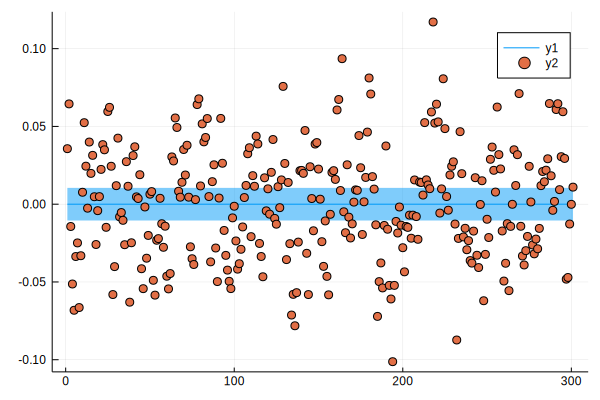

In [15]:
start = 15000
finish = 15300

plot(m_predictions[start:finish], ribbon=sqrt.(v_predictions[start:finish]))
scatter!(x_drill[start:finish])
#ylims!(-0.1, 0.1)

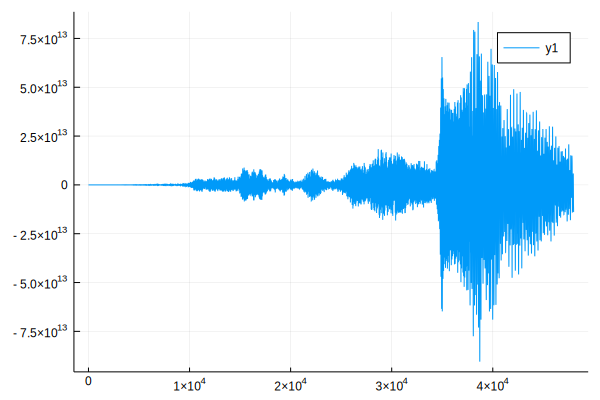

In [16]:
plot(m_predictions/var(m_predictions))

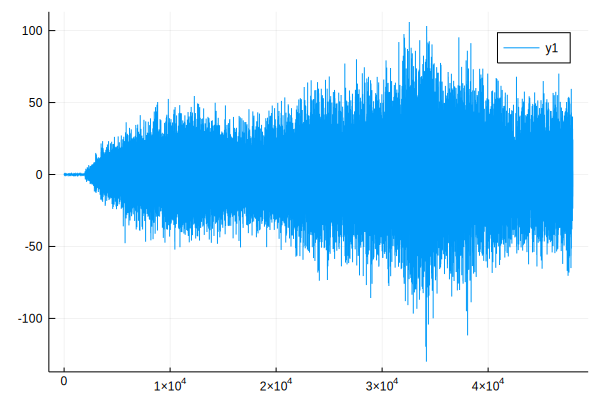

In [17]:
plot(x_drill/var(x_drill))

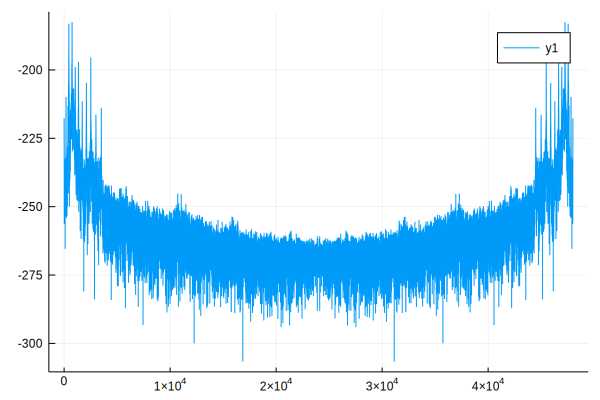

In [18]:
plot(20*log10.(abs.(FFTW.fft(m_predictions))))

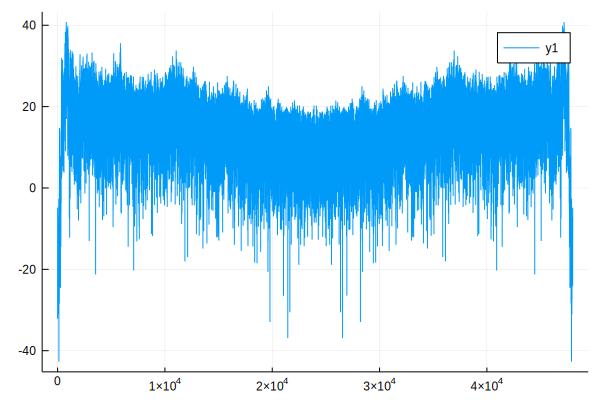

In [19]:
plot(20*log10.(abs.(FFTW.fft(x_drill))))